In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests, zipfile, io, re

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

In [ ]:
#download the dataset

url = "https://files.consumerfinance.gov/ccdb/complaints.csv.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("consumer_complaints")

In [2]:
file_path = "consumer_complaints/complaints.csv"
data = pd.read_csv(file_path)
data = data[['Product', 'Consumer complaint narrative']].dropna()

In [3]:
subset_size = min(30000, len(data))
data = data.sample(n=subset_size, random_state=42)
print("Subset size:", len(data))


Subset size: 30000


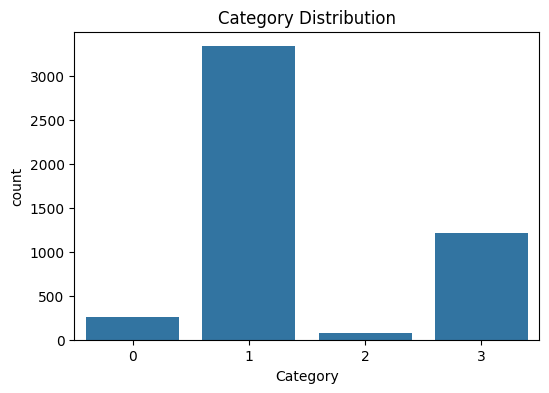

In [4]:
#mapping the products
category_map = {
    'Credit reporting': 0,
    'Credit repair services': 0,
    'Other financial service': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}

data = data[data['Product'].isin(category_map.keys())]
data['Category'] = data['Product'].map(category_map)

plt.figure(figsize=(6,4))
sns.countplot(x='Category', data=data)
plt.title("Category Distribution")
plt.show()


In [5]:
stop_words = set([
    'a', 'an', 'the', 'and', 'or', 'is', 'are', 'was', 'were', 'in', 'on',
    'at', 'of', 'for', 'to', 'from', 'by', 'with', 'i', 'you', 'my', 'me',
    'we', 'our', 'us', 'it', 'this', 'that', 'be', 'as', 'not', 'but'
])

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = [word for word in text.split() if word not in stop_words]
    return " ".join(words)

data['clean_text'] = data['Consumer complaint narrative'].apply(preprocess_text)


In [6]:
X = data['clean_text']
y = data['Category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [7]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2, max_df=0.8, sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [8]:
#for class imbalance handling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)


In [12]:
# Define all models including XGBoost
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, class_weight='balanced'),
        "params": {"C": [0.1, 1, 10], "solver": ["lbfgs"]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'),
        "params": {"n_estimators": [100, 200], "max_depth": [10, 20, None]}
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        "params": {"max_depth": [10, 20, None]}
    },
    "Naive Bayes": {
        "model": MultinomialNB(),
        "params": {"alpha": [0.01, 0.1, 1]}
    },
}

# Train models with RandomizedSearchCV
best_models = {}
results = {}

for name, m in models.items():
    print(f"Training {name}...")
    rs = RandomizedSearchCV(
        m["model"], m["params"], n_iter=5, cv=3, scoring='accuracy', n_jobs=-1, random_state=42
    )
    rs.fit(X_train_res, y_train_res)
    best_models[name] = rs.best_estimator_
    results[name] = rs.best_score_
    print(f"Best CV Accuracy: {rs.best_score_:.4f}")
    print(f"Best Params: {rs.best_params_}\n")

Training Logistic Regression...


/home/mukesh/task-5/venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best CV Accuracy: 0.9857
Best Params: {'solver': 'lbfgs', 'C': 10}

Training Random Forest...
Best CV Accuracy: 0.9716
Best Params: {'n_estimators': 200, 'max_depth': None}

Training Decision Tree...


/home/mukesh/task-5/venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best CV Accuracy: 0.9322
Best Params: {'max_depth': None}

Training Naive Bayes...
Best CV Accuracy: 0.9656
Best Params: {'alpha': 0.01}



/home/mukesh/task-5/venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [13]:
best_model_name = max(results, key=results.get)
best_model = best_models[best_model_name]
print(f"Selected Best Model: {best_model_name} with CV Accuracy: {results[best_model_name]:.4f}")

# Fit the best model on resampled training data
best_model.fit(X_train_res, y_train_res)

# Predictions on test set
y_pred = best_model.predict(X_test_tfidf)

Selected Best Model: Logistic Regression with CV Accuracy: 0.9857


Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.60      0.69        53
           1       0.95      0.97      0.96       666
           2       0.78      0.44      0.56        16
           3       0.93      0.93      0.93       242

    accuracy                           0.93       977
   macro avg       0.86      0.74      0.78       977
weighted avg       0.93      0.93      0.93       977

Overall Accuracy: 0.9335


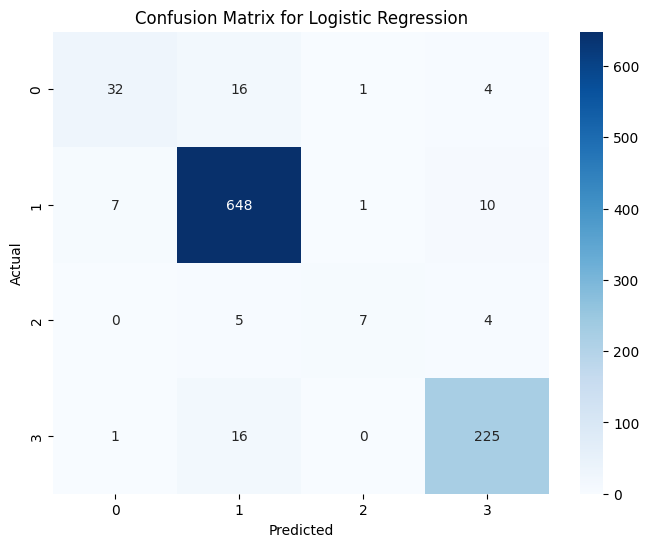

In [14]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

acc = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {acc:.4f}")

# Confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

In [15]:
feature_names = tfidf.get_feature_names_out()

if isinstance(best_model, LogisticRegression):
    coefs = best_model.coef_
    for i, category in enumerate([0,1,2,3]):
        top_features = np.argsort(coefs[i])[-10:]
        print(f"Top words for category {i}: {[feature_names[j] for j in top_features]}")
elif isinstance(best_model, (RandomForestClassifier, DecisionTreeClassifier, XGBClassifier)):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[-10:]
    print(f"Top features influencing {best_model_name}:")
    for idx in indices:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")
elif isinstance(best_model, MultinomialNB):
    coefs = best_model.feature_log_prob_
    for i, category in enumerate([0,1,2,3]):
        top_features = np.argsort(coefs[i])[-10:]
        print(f"Top words for category {i} (NB): {[feature_names[j] for j in top_features]}")
else:
    print("This model type does not provide feature importance.")


Top words for category 0: ['credit card', 'credit report', 'all xxxx', 'inquiries', 'alert', 'card', 'report', 'transunion', 'equifax', 'experian']
Top words for category 1: ['accounts', 'company', 'inaccuracies', 'collector', 'owed', 'owe', 'collect', 'xxxx xxxx', 'collection', 'debt']
Top words for category 2: ['santander', 'nt', 'dealership', 'ally', 'auto', 'payment', 'honda', 'loan', 'car', 'vehicle']
Top words for category 3: ['property', 'mortgage company', 'closing', 'foreclosure', 'lender', 'loan', 'modification', 'escrow', 'home', 'mortgage']


In [16]:
new_texts = [
    "I cannot get my credit report fixed",
    "Debt collector called me for wrong bill",
    "Mortgage payment was overcharged",
    "Loan application denied unfairly"
]

new_texts_clean = [preprocess_text(text) for text in new_texts]
new_tfidf = tfidf.transform(new_texts_clean)

preds = best_model.predict(new_tfidf)

for text, pred in zip(new_texts, preds):
    print(f"Text: '{text}' --> Predicted Category: {pred}")

Text: 'I cannot get my credit report fixed' --> Predicted Category: 0
Text: 'Debt collector called me for wrong bill' --> Predicted Category: 1
Text: 'Mortgage payment was overcharged' --> Predicted Category: 3
Text: 'Loan application denied unfairly' --> Predicted Category: 3
